In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

<h2>過学習</h2>
<p>機械学習において、訓練データに過剰に適合するあまり未知の入力データに対して正しく推定することができなくなってしまうことがあり、これを<b>過学習(Overlerning)</b></p>
<p>過学習は、特定のパターンのみに最適化された局所最適解に陥っている状態だと考えることもできる</p>

<h2>多層化に伴う問題への対策</h2>
<ul>
    <li>バッチサイズの最適化</li>
    <li>ハイパーパラメータの最適化</li>
    <li>正則化</li>
    <li>重みの初期値の最適化</li>
    <li>早期終了</li>
    <li>データ拡張</li>
    <li>ドロップアウト</li>
    <li>データの前処理</li>
</ul>

<p>ハイパーパラメータ：学習係数やニューロンの数などの学習前にあらかじめ決めておく必要があるパラメータ</p>

<h3>正則化</h3>
<p>データをある範囲に収まるように変換する。<br>
モノクロ画像の各画素は0から255の範囲だが、これを255で割ることで0から1の範囲に収めることができる。</p>

In [2]:
def normalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    return (x - x_min) / (x_max - x_min)

<h2>ドロップアウト(Dropout)</h2>
<p>ドロップアウトは、出力層以外のニューロンを一定の確率でランダムに消去するテクニック<br>
規模の大きなネットワークは過学習を起こしやすいが、ドロップアウトを用いることでネットワークの規模を下げることができる。</p>

<h2>ディープラーニングの実装</h2>
<p>中間層の活性化関数：ReLU<br>
出力層の活性化関数：ソフトマックス関数<br>
損失関数：交差エントロピー誤差<br>
最適化アルゴリズム：確率的勾配降下法<br>
バッチサイズ：8<br>
中間層のニューロン数：25</p>

手順
<ol>
    <li>データの入手と前処理</li>
    <li>各層の実装</li>
    <li>ニューラルネットワークの実装</li>
    <li>ミニバッチ法による学習</li>
    <li>正解率の測定</li>
</ol>

In [60]:
# -- Irisデータの読み込み --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)  # サンプル数

In [61]:
# -- 入力データを標準化する --
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

In [62]:
# -- 正解をone-hot表現にする --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [63]:
# -- 訓練データとテストデータ --
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

In [64]:
# -- 各設定値 --
n_in = 4  # 入力層のニューロン数
n_mid = 25  # 中間層のニューロン数
n_out = 3  # 出力層のニューロン数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 1000
batch_size = 8
interval = 100  # 経過の表示間隔

In [65]:
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
#     def __init__(self, n_upper, n):
#         self.w = wb_width * np.random.randn(n_upper, n) #重み
#         self.b = wb_width * np.random.randn(n) #バイアス
        
#     def update(self, eta):      
#         self.w -= eta * self.grad_w
#         self.b -= eta * self.grad_b

In [66]:
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)  # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLUの微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

In [67]:
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

In [68]:
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio
        
    def forward(self, x, is_train):
        if is_train:
            rand = np.random.rand(*x.shape) #乱数の行列
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout #ニューロンをランダムに無効化
        else:
            self.y = (1 - self.dropout_ratio)*x
        
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout

In [69]:
# -- 各層の初期化 --
# middle_layer_1 = MiddleLayer(n_in, n_mid)
# middle_layer_2 = MiddleLayer(n_mid, n_mid)
# output_layer = OutputLayer(n_mid, n_out)
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

In [70]:
# -- 順伝播 --
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)

In [71]:
# -- 逆伝播 --
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)

In [72]:
# -- 重みとバイアスの更新 --
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

In [73]:
# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y+ 1e-7)) / batch_size  # 交差エントロピー誤差

Epoch:0/1000 Error_train:1.1090655739368458 Error_test:1.1089021377771913
Epoch:100/1000 Error_train:0.3437644528828617 Error_test:0.33397595064926644
Epoch:200/1000 Error_train:0.23648085301314012 Error_test:0.22813806500162523
Epoch:300/1000 Error_train:0.1779877209409456 Error_test:0.16919777056117336
Epoch:400/1000 Error_train:0.13034816011267875 Error_test:0.13446019388288075
Epoch:500/1000 Error_train:0.10509370626885266 Error_test:0.11453893810239528
Epoch:600/1000 Error_train:0.08953930079976916 Error_test:0.10364161195380331
Epoch:700/1000 Error_train:0.07859517278265782 Error_test:0.09493471268059955
Epoch:800/1000 Error_train:0.07004249668049348 Error_test:0.08881429739905602
Epoch:900/1000 Error_train:0.0640901899999221 Error_test:0.08567314437054115


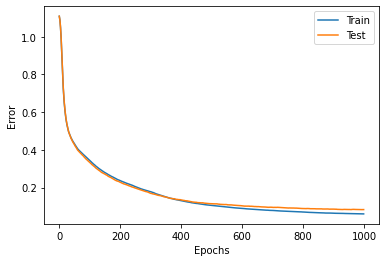

Accuracy Train: 98.66666666666667% Accuracy Test: 96.0%


In [74]:
# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size  # 1エポックあたりのバッチ数
for i in range(epoch):

    # -- 誤差の計測 --  
    forward_propagation(input_train, False)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test, False)
    error_test = get_error(correct_test, n_test)
    
    # -- 誤差の記録 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))

    # -- 学習 -- 
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 順伝播と逆伝播
        forward_propagation(x, True)
        backpropagation(t)
        
        # 重みとバイアスの更新
        uppdate_wb() 

        
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
forward_propagation(input_train, False)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")